# Quanvolution

# Packages

In [18]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

## Story

![Quanvolutional.png](Quanvolutional.png)

## Variables initiatialisation

In [19]:
n_epochs = 50   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "_static/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Prenons un cas simple. Utilisons MNIST qui est un dataset de chiffres "handwritten" de 0 à 9 que le modèle va devoir classer. Seule une petite partie du dataset va être utilisée. Les paramètres précédents permettent de sélection un sous ensemble de données, 50 images pour l'entrainement et 30 pour le test. Les données doivent ensuite être normalisées en divisant par 255 (échelle de pixel de 0 à 255) afin de ramener les valeurs de 0 à 1. 

In [21]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

On génère un circuit pour processer les données. `RandomLayers` permet de générer un circuit aléatoire en fonction de portes à 1 qubit et de portes à 2 qubits.

In [22]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

La fonction suivante fait office de l'application d'un kernel 2x2 avec un stride de 2. Ce qui permet de réduire la dimension des images par deux. 

In [39]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

## Quantum pre-processing of the dataset

Comme nous n'allons pas entraîner la couche de convolution quantique, il est plus efficace de l'appliquer en tant que couche de "prétraitement" à toutes les images de notre ensemble de données. Plus tard, un modèle entièrement classique sera directement entraîné et testé sur l'ensemble de données prétraitées, ce qui évitera de répéter inutilement les calculs quantiques.

Les images prétraitées seront enregistrées dans le dossier `SAVE_PATH`. Une fois sauvegardées, elles peuvent être chargées directement en réglant `PREPROCESS = False`, sinon la convolution quantique est évaluée à chaque exécution du code.

In [40]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


Visualisons l'effet de l'application de la couche de convolution quantique sur les images.

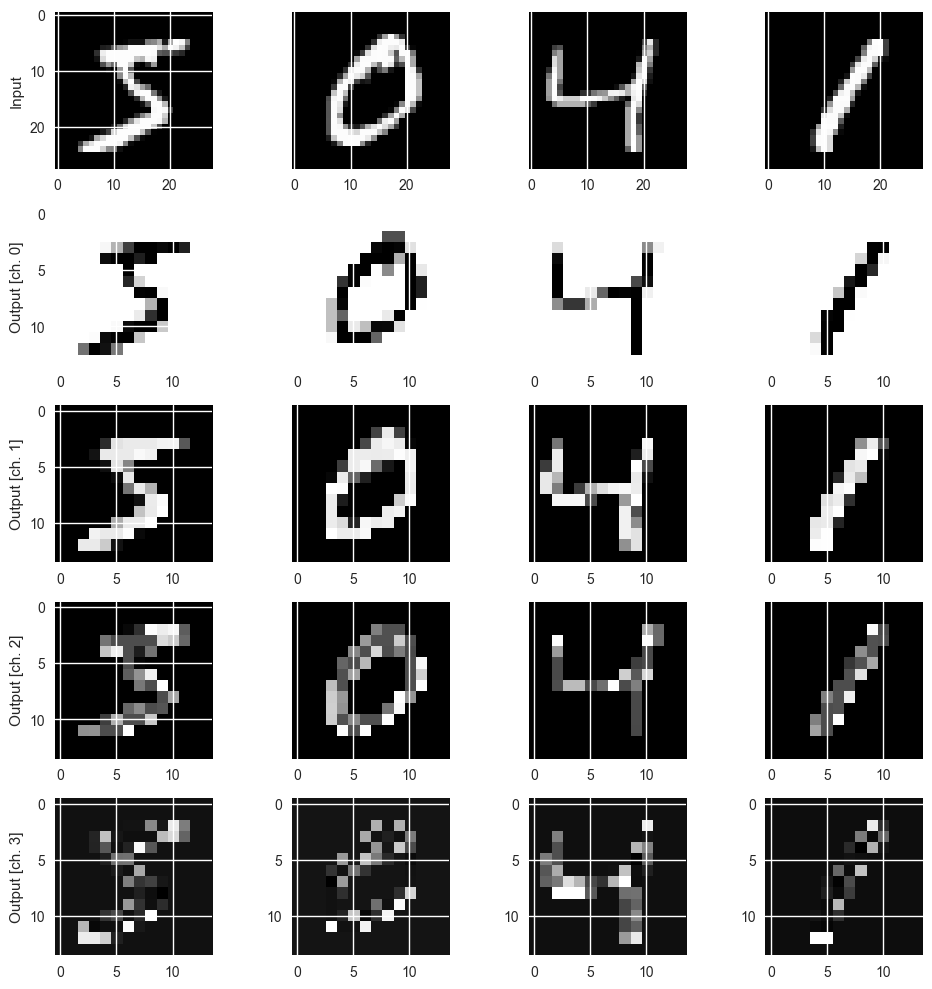

In [41]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Sous chaque image d'entrée, le  4 canaux de sortie générés par la convolution quantique sont visualisés en niveaux de gris.

On peut clairement remarquer le sous-échantillonnage de la résolution et une certaine distorsion locale introduite par le noyau quantique. En revanche, la forme globale de l'image est préservée, comme prévu pour une couche de convolution.

## Hybrid quantum-classical model

Après l'application de la couche de convolution quantique, nous introduisons les caractéristiques obtenues dans un réseau neuronal classique qui sera entraîné à classer les 10 chiffres différents de l'ensemble de données MNIST.

Nous utilisons un modèle très simple : juste une couche entièrement connectée avec 10 nœuds de sortie avec une fonction d'activation `softmax` finale.

Le modèle est compilé avec un optimiseur stochastique de descente de gradient et une fonction de perte d'entropie croisée.


In [10]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

### Training

Nous initialisons d'abord une instance du modèle, puis nous l'entraînons et le validons avec l'ensemble de données qui a déjà été prétraité par une convolution quantique.

#### Modele classique après la convolution quantique

In [15]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/50
13/13 - 0s - loss: 2.5087 - accuracy: 0.1600 - val_loss: 2.0768 - val_accuracy: 0.2667 - 370ms/epoch - 28ms/step
Epoch 2/50
13/13 - 0s - loss: 1.9411 - accuracy: 0.2200 - val_loss: 1.8518 - val_accuracy: 0.4000 - 22ms/epoch - 2ms/step
Epoch 3/50
13/13 - 0s - loss: 1.5874 - accuracy: 0.5200 - val_loss: 1.8082 - val_accuracy: 0.4000 - 21ms/epoch - 2ms/step
Epoch 4/50
13/13 - 0s - loss: 1.2837 - accuracy: 0.5600 - val_loss: 1.5938 - val_accuracy: 0.5667 - 21ms/epoch - 2ms/step
Epoch 5/50
13/13 - 0s - loss: 1.0930 - accuracy: 0.8200 - val_loss: 1.4939 - val_accuracy: 0.5333 - 20ms/epoch - 2ms/step
Epoch 6/50
13/13 - 0s - loss: 0.9326 - accuracy: 0.8600 - val_loss: 1.4363 - val_accuracy: 0.5667 - 20ms/epoch - 2ms/step
Epoch 7/50
13/13 - 0s - loss: 0.7445 - accuracy: 0.9200 - val_loss: 1.3598 - val_accuracy: 0.6333 - 21ms/epoch - 2ms/step
Epoch 8/50
13/13 - 0s - loss: 0.6169 - accuracy: 0.9800 - val_loss: 1.2712 - val_accuracy: 0.5333 - 19ms/epoch - 1ms/step
Epoch 9/50
13/13 - 0s 

### Modele classique sur les données normalisées

Afin de comparer les résultats obtenus avec et sans la couche de convolution quantique, nous initialisons également une instance "classique" du modèle qui sera directement entraînée et validée avec les images MNIST brutes (c'est-à-dire sans prétraitement quantique).

In [16]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/50
13/13 - 0s - loss: 2.4134 - accuracy: 0.0800 - val_loss: 2.2604 - val_accuracy: 0.2000 - 232ms/epoch - 18ms/step
Epoch 2/50
13/13 - 0s - loss: 2.0243 - accuracy: 0.3000 - val_loss: 2.0998 - val_accuracy: 0.2333 - 20ms/epoch - 2ms/step
Epoch 3/50
13/13 - 0s - loss: 1.7160 - accuracy: 0.5400 - val_loss: 1.9580 - val_accuracy: 0.4000 - 22ms/epoch - 2ms/step
Epoch 4/50
13/13 - 0s - loss: 1.4776 - accuracy: 0.7400 - val_loss: 1.8324 - val_accuracy: 0.6000 - 21ms/epoch - 2ms/step
Epoch 5/50
13/13 - 0s - loss: 1.2722 - accuracy: 0.8200 - val_loss: 1.7156 - val_accuracy: 0.6000 - 19ms/epoch - 1ms/step
Epoch 6/50
13/13 - 0s - loss: 1.1102 - accuracy: 0.9200 - val_loss: 1.6214 - val_accuracy: 0.5333 - 19ms/epoch - 1ms/step
Epoch 7/50
13/13 - 0s - loss: 0.9676 - accuracy: 0.9400 - val_loss: 1.5509 - val_accuracy: 0.5333 - 21ms/epoch - 2ms/step
Epoch 8/50
13/13 - 0s - loss: 0.8497 - accuracy: 0.9400 - val_loss: 1.4791 - val_accuracy: 0.6333 - 19ms/epoch - 1ms/step
Epoch 9/50
13/13 - 0s 

## Results

Nous pouvons enfin tracer la précision du test et la perte de test en fonction du nombre d'époques d'apprentissage.

/var/folders/__/yb0d9fls4r9gb8t6yccwhq_w0000gn/T/ipykernel_44728/925943430.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


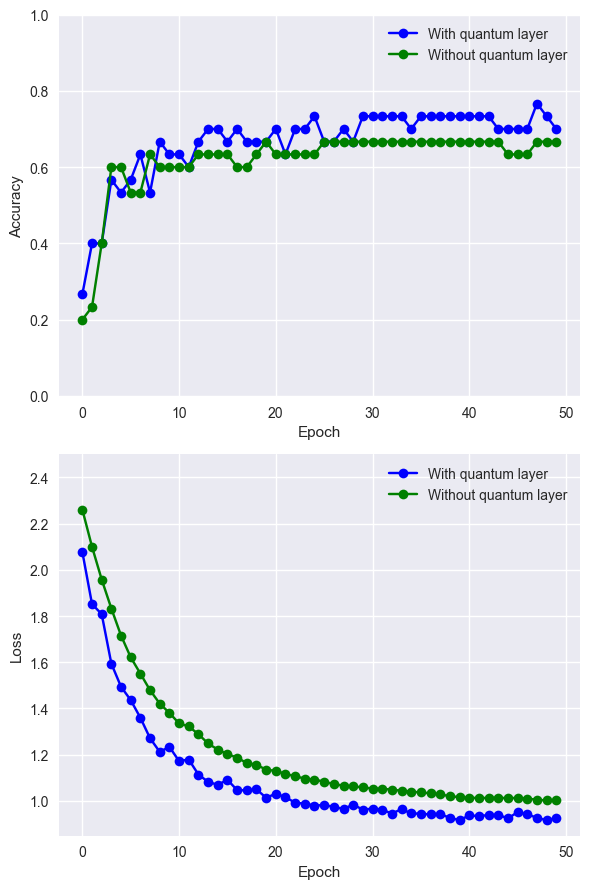

In [17]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

## Source

- [PennyLane Demo - Quanvolution](https://pennylane.ai/qml/demos/tutorial_quanvolution/)